### Immune system gene expression and aging

We will use a dataset distributed by the [OneK1K](https://onek1k.org/) project, which includes single-cell RNA-seq data from peripheral blood mononuclear cells (PBMCs) obtained from 982 donors, comprising more than 1.2 million cells in total.  These data are released under a Creative Commons Zero Public Domain Dedication and are thus free to reuse, with the restriction that users agree not to attempt to reidentify the participants.  

The flagship paper for this study is:

Yazar S., Alquicira-Hernández J., Wing K., Senabouth A., Gordon G., Andersen S., Lu Q., Rowson A., Taylor T., Clarke L., Maccora L., Chen C., Cook A., Ye J., Fairfax K., Hewitt A., Powell J. Single cell eQTL mapping identified cell type specific control of autoimmune disease. Science, 376, 6589 (2022)

We will use the data to ask a simple question: how does gene expression in PBMCs change with age?

In [29]:
import anndata as ad
from anndata.experimental import read_lazy
import dask.array as da
import h5py
import numpy as np
import scanpy as sc
from pathlib import Path
import os

datadir = Path('/Users/poldrack/data_unsynced/BCBS/immune_aging/')

In [30]:
datafile = datadir / 'a3f5651f-cd1a-4d26-8165-74964b79b4f2.h5ad'
url = 'https://datasets.cellxgene.cziscience.com/a3f5651f-cd1a-4d26-8165-74964b79b4f2.h5ad'
dataset_name = 'OneK1K'

if not datafile.exists():
    cmd = f'wget -O {datafile.as_posix()} {url}'
    print(f'Downloading data from {url} to {datafile.as_posix()}')
    os.system(cmd)

load_annotation_index = True
adata = read_lazy(h5py.File(datafile, 'r'),
    load_annotation_index=load_annotation_index)

In [31]:
print(adata)

AnnData object with n_obs × n_vars = 1248980 × 35528
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'donor_id', 'pool_number', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'age', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'cell_type_ontology_term_id_colors', 'citation', 'default_embedding', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_azi

In [32]:
unique_cell_types = np.unique(adata.obs['cell_type'])
print(unique_cell_types)

['CD14-low, CD16-positive monocyte' 'CD14-positive monocyte'
 'CD16-negative, CD56-bright natural killer cell, human'
 'CD4-positive, alpha-beta T cell'
 'CD4-positive, alpha-beta cytotoxic T cell'
 'CD8-positive, alpha-beta T cell'
 'central memory CD4-positive, alpha-beta T cell'
 'central memory CD8-positive, alpha-beta T cell'
 'conventional dendritic cell' 'dendritic cell'
 'double negative thymocyte'
 'effector memory CD4-positive, alpha-beta T cell'
 'effector memory CD8-positive, alpha-beta T cell' 'erythrocyte'
 'gamma-delta T cell' 'hematopoietic precursor cell'
 'innate lymphoid cell' 'memory B cell' 'mucosal invariant T cell'
 'naive B cell' 'naive thymus-derived CD4-positive, alpha-beta T cell'
 'naive thymus-derived CD8-positive, alpha-beta T cell'
 'natural killer cell' 'peripheral blood mononuclear cell' 'plasmablast'
 'plasmacytoid dendritic cell' 'platelet' 'regulatory T cell'
 'transitional stage B cell']


### Filtering out bad donors

Donor Cell Count Statistics:
count     981.000000
mean     1273.170234
std       322.280557
min       333.000000
25%      1070.000000
50%      1246.000000
75%      1446.000000
max      3511.000000
Name: count, dtype: float64
cutoff of 894 would exclude 98 donors


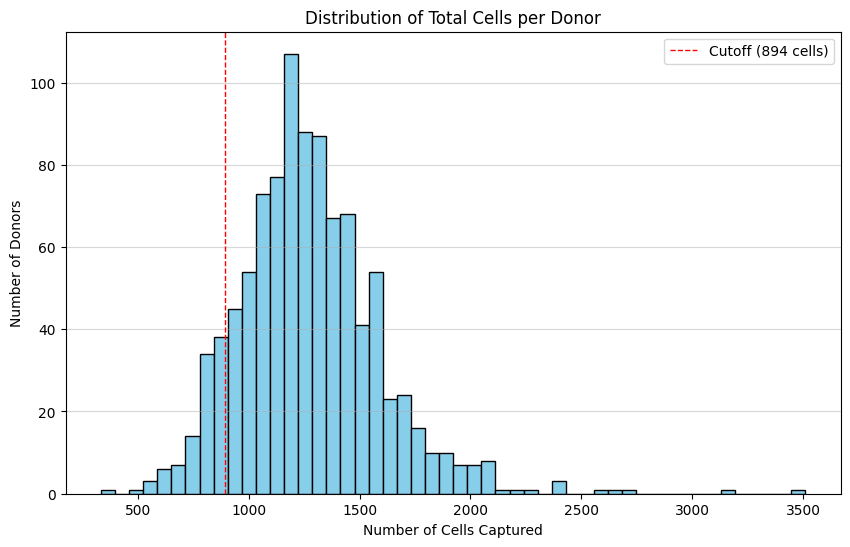

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import scoreatpercentile

# 1. Calculate how many cells each donor has
donor_cell_counts = pd.Series(adata.obs['donor_id']).value_counts()

# Print some basic statistics to read the exact numbers
print("Donor Cell Count Statistics:")
print(donor_cell_counts.describe())

# 2. Plot the histogram
plt.figure(figsize=(10, 6))
# Bins set to 'auto' or a fixed number depending on your N of donors
plt.hist(donor_cell_counts.values, bins=50, color='skyblue', edgecolor='black')

plt.title('Distribution of Total Cells per Donor')
plt.xlabel('Number of Cells Captured')
plt.ylabel('Number of Donors')
plt.grid(axis='y', alpha=0.5)

# Optional: Draw a vertical line at the propsoed cutoff
# This helps you visualize how many donors you would lose.
cutoff_percentile = 10  # e.g., 10th percentile
min_cells_per_donor = int(scoreatpercentile(donor_cell_counts.values, cutoff_percentile))
print(f'cutoff of {min_cells_per_donor} would exclude {(donor_cell_counts < min_cells_per_donor).sum()} donors')
plt.axvline(min_cells_per_donor, color='red', linestyle='dashed', linewidth=1, label=f'Cutoff ({min_cells_per_donor} cells)')
plt.legend()

plt.show()

In [34]:
print(f"Filtering to keep only donors with at least {min_cells_per_donor} cells.")
print(f"Number of donors excluded: {(donor_cell_counts < min_cells_per_donor).sum()}")
valid_donors = donor_cell_counts[donor_cell_counts >= min_cells_per_donor].index
adata = adata[adata.obs['donor_id'].isin(valid_donors)]

Filtering to keep only donors with at least 894 cells.
Number of donors excluded: 98


In [35]:
print(f'Number of donors after filtering: {len(valid_donors)}')

Number of donors after filtering: 883


### Filtering cell types by frequency

Drop cell types that don't have at least 10 cells for at least 95% of people

In [36]:
import pandas as pd

# 1. Calculate the count of cells for each 'cell_type' within each 'donor_id'
# We use pandas crosstab on adata.obs, which is loaded in memory.
counts_per_donor = pd.crosstab(adata.obs['donor_id'], adata.obs['cell_type'])

# 2. Identify cell types to keep
# Keep if >= 10 cells in at least 90% of donors

min_cells = 10
percent_donors = 0.9
donor_count = counts_per_donor.shape[0]
cell_types_to_keep = counts_per_donor.columns[
    (counts_per_donor >= min_cells).sum(axis=0) >= (donor_count * percent_donors)]

print(f"Keeping {len(cell_types_to_keep)} cell types out of {len(counts_per_donor.columns)}")
print(f"Cell types to keep: {cell_types_to_keep.tolist()}")

# 3. Filter the AnnData object
# We subset the AnnData to include only observations belonging to the valid cell types.
adata_filtered = adata[adata.obs['cell_type'].isin(cell_types_to_keep)]

Keeping 8 cell types out of 29
Cell types to keep: ['central memory CD4-positive, alpha-beta T cell', 'effector memory CD4-positive, alpha-beta T cell', 'effector memory CD8-positive, alpha-beta T cell', 'memory B cell', 'naive B cell', 'naive thymus-derived CD4-positive, alpha-beta T cell', 'natural killer cell', 'regulatory T cell']


In [37]:
# now drop subjects who have any zeros in these cell types
donor_celltype_counts = pd.crosstab(adata_filtered.obs['donor_id'], adata_filtered.obs['cell_type'])
valid_donors_final = donor_celltype_counts.index[
    (donor_celltype_counts >= min_cells).all(axis=1)]
adata_filtered = adata_filtered[adata_filtered.obs['donor_id'].isin(valid_donors_final)]
print(f"Final number of donors after filtering: {len(valid_donors_final)}")

Final number of donors after filtering: 698


In [38]:

print("Loading data into memory (this can take a few minutes)...")
adata_loaded = adata_filtered.to_memory()

# filter out genes with zero counts across all selected cells
print("Filtering genes with zero counts...")
sc.pp.filter_genes(adata_loaded, min_counts=1)


Loading data into memory (this can take a few minutes)...
Filtering genes with zero counts...


In [39]:
print(adata_loaded)


AnnData object with n_obs × n_vars = 785021 × 29331
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'donor_id', 'pool_number', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'age', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_counts'
    uns: 'citation', 'default_embedding', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_azimuth_spca', 'X_azimuth_uma

In [40]:
adata_loaded.write(datadir /  f'dataset-{dataset_name}_subset-immune_filtered.h5ad')

In [41]:
!ls -lh /Users/poldrack/data_unsynced/BCBS/immune_aging

total 22022184
-rw-r--r--@ 1 poldrack  staff   4.1G Dec 19 09:03 a3f5651f-cd1a-4d26-8165-74964b79b4f2.h5ad
-rw-r--r--@ 1 poldrack  staff   6.4G Dec 20 09:36 dataset-OneK1K_subset-immune_filtered.h5ad
-rw-r--r--  1 poldrack  staff   185B Dec 19 09:02 get_data.sh
